# Malang City Hotel Recommendation System Based on Collaborative Filtering
<hr>

#### Source Dataset:
#### Oleh: [[Mikail](https://linkedin.com/in/mikailjordan), [Fander](https://https://linkedin.com/in/m-wahyu-elfander), [Salsa](https://linkedin.com/in/salsabila-azizah-abel)]

# 1. Data Preparation

## Import Library

In [1]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## Preparing the Dataset used

In [2]:
# Upload semua dataset yang dipakai
from google.colab import files
uploaded = files.upload()

Saving Hotel Malang 1-5 score.csv to Hotel Malang 1-5 score.csv
Saving rating_data_shuffled(2).csv to rating_data_shuffled(2).csv
Saving user.csv to user.csv


##### Keterangan:
* Hotel Malang 1-5 score.csv - mengandung informasi tempat hotel/penginapan di kota Batu dan Malang
* rating_data.csv - mengandung informasi pengguna, tempat hotel, dan rating untuk membuat sistem rekomendasi berdasar rating
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna

# 2. Data Understanding

## Prepare Data

In [3]:
# Memuat dataset hotel dan user

hotel = pd.read_csv('Hotel Malang 1-5 score.csv')
user = pd.read_csv('user.csv')
rating = pd.read_csv('rating_data_shuffled(2).csv')

## Exploration of Features in Data

### Data Hotel

In [4]:
# Melihat gambaran data hotel

hotel.head()

,hotel_id,hotel_name,review_score,hotel_price
0,401,Golden Tulip Hoolland Resort Batu,4.9,"Rp900,000"
1,402,Grand Mercure Malang Mirama,4.9,"Rp977,500"
2,403,The Singhasari Resort Batu,5.0,"Rp1,200,000"
3,404,The Shalimar Boutique Hotel,5.0,"Rp1,200,000"
4,405,Jambuluwuk Convention Hall & Resort Batu,4.6,"Rp814,492"


In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hotel_id      30 non-null     int64  
 1   hotel_name    30 non-null     object 
 2   review_score  30 non-null     float64
 3   hotel_price   30 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ KB


### Data Rating

In [6]:
# Melihat gambaran data rating

rating.head()

,User_Id,hotel_id,hotel_rating
0,175,401,5
1,222,402,5
2,82,403,5
3,242,404,5
4,180,405,5


In [7]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   User_Id       300 non-null    int64
 1   hotel_id      300 non-null    int64
 2   hotel_rating  300 non-null    int64
dtypes: int64(3)
memory usage: 7.2 KB


In [8]:
# Merubah data rating agar hanya berisi rating pada tempat hotel dari Kota Malang

rating = pd.merge(rating, hotel[['hotel_id']], how='right', on='hotel_id')
rating.head()

,User_Id,hotel_id,hotel_rating
0,175,401,5
1,31,401,5
2,249,401,5
3,78,401,5
4,9,401,5


In [9]:
# Melihat ukuran dataset rating untuk Kota Malang

rating.shape

(300, 3)

### Data user

In [10]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Malang, Jawa Timur",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Malang, Jawa Timur",21
4,5,"Lampung, Sumatera Selatan",20


In [11]:
# Merubah data user agar hanya berisi user yang pernah megunjungi Hotel di Kota Malang

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
148,1,"Semarang, Jawa Tengah",20
85,2,"Malang, Jawa Timur",21
215,3,"Cirebon, Jawa Barat",23
232,4,"Malang, Jawa Timur",21
112,5,"Lampung, Sumatera Selatan",20


In [12]:
# Melihat dataset user yang pernah memberi rating pada Hotel di Kota Malang

user.shape

(300, 3)

## Eksplorasi Data

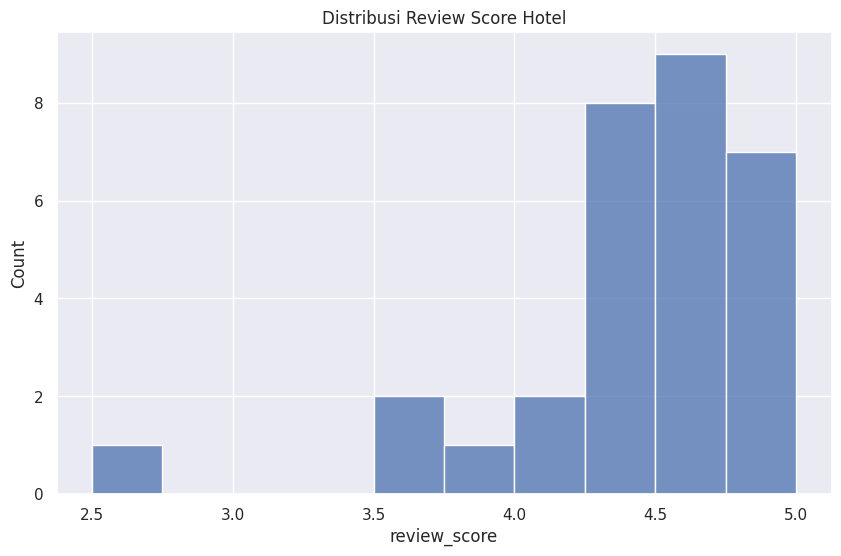

In [13]:
# Visualisasi data score hotel di Malang
plt.figure(figsize=(10, 6))
sns.histplot(data=hotel, x='review_score', bins=10)
plt.title('Distribusi Review Score Hotel')
plt.show()

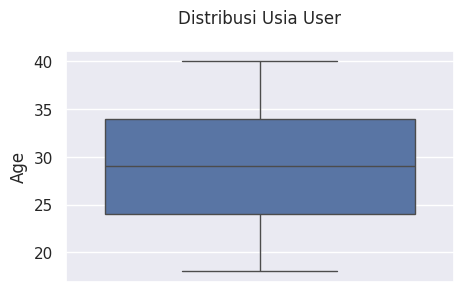

In [14]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

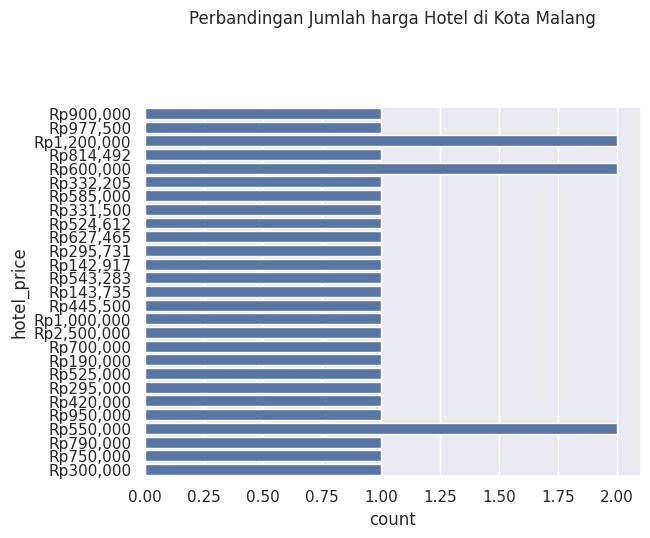

In [15]:
# Membuat visualisasi distribusi harga Hotel di Kota Malang

sns.countplot(y='hotel_price', data=hotel)
plt.title('Perbandingan Jumlah harga Hotel di Kota Malang', pad=60)
plt.show()

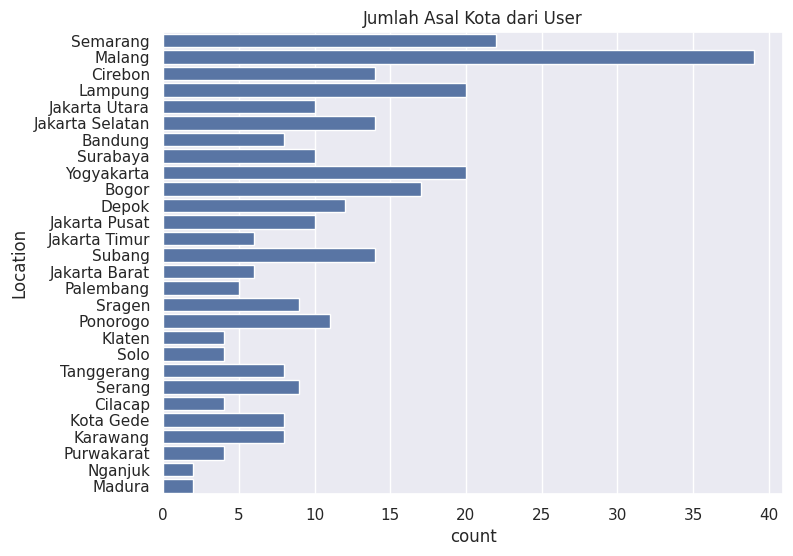

In [16]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## Data Preparation for Modeling

### Create a Copy of Rating Data

In [17]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,hotel_id,hotel_rating
0,175,401,5
1,31,401,5
2,249,401,5
3,78,401,5
4,9,401,5


### Performing Encoding

#### Creating a Function to Perform Encoding

In [18]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### Encoding and Mapping User Columns

In [19]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### Encoding and Mapping Hotel Columns

In [20]:
# Encoding hotel_Id
hotel_to_hotel_encoded, hotel_encoded_to_hotel = dict_encoder('hotel_id')

# Mapping hotel_id ke dataframe hotel
df['hotel'] = df['hotel_id'].map(hotel_to_hotel_encoded)

### Viewing Data Overview for Modeling

In [21]:
# Mendapatkan jumlah user dan hotel
num_user, num_hotel = len(user_to_user_encoded), len(hotel_to_hotel_encoded)

# Mengubah rating menjadi nilai float
df['hotel_rating'] = df['hotel_rating'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['hotel_rating']), max(df['hotel_rating'])

print(f'Number of User: {num_user}, Number of Hotel: {num_hotel}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Hotel: 30, Min Rating: 2.0, Max Rating: 5.0


In [22]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,hotel_id,hotel_rating,user,hotel
203,76,421,4.0,203,20
266,256,427,5.0,266,26
152,279,416,5.0,152,15
9,210,401,4.0,9,0
233,192,424,5.0,233,23


## Machine Learning Modeling with RecommenderNet

### Splitting train and test data

In [23]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'hotel']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['hotel_rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.87 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### Setup the Model

#### Function Initialization

In [24]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_user, num_hotel, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_user = num_user
    self.num_hotel = num_hotel
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_user, 1) # layer embedding user bias
    self.hotel_embedding = layers.Embedding( # layer embeddings places
        num_hotel,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.hotel_bias = layers.Embedding(num_hotel, 1) # layer embedding places bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    hotel_vector = self.hotel_embedding(inputs[:, 1]) # memanggil layer embedding 3
    hotel_bias = self.hotel_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_hotel = tf.tensordot(user_vector, hotel_vector, 2)

    x = dot_user_hotel + user_bias + hotel_bias

    return tf.nn.sigmoid(x) # activation sigmoid

#### Model Initialization

In [25]:
model = RecommenderNet(num_user, num_hotel, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.000004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#### Callbacks Initialization

In [26]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.20):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

#### Training Process

In [27]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 1000,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/1000
9/9 [==============================] - 2s 41ms/step - loss: 0.7523 - root_mean_squared_error: 0.4677 - val_loss: 0.7715 - val_root_mean_squared_error: 0.4804
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.7237 - root_mean_squared_error: 0.4657 - val_loss: 0.7715 - val_root_mean_squared_error: 0.4804
Epoch 3/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.7790 - root_mean_squared_error: 0.4906 - val_loss: 0.7715 - val_root_mean_squared_error: 0.4804
Epoch 4/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.7382 - root_mean_squared_error: 0.4726 - val_loss: 0.7714 - val_root_mean_squared_error: 0.4804
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6722 - root_mean_squared_error: 0.4404 - val_loss: 0.7714 - val_root_mean_squared_error: 0.4804
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6696 - root_mean_squared_error: 0.4386 - val_loss: 0.7714 - val_root_mean_s

In [34]:
# Simpan model TensorFlow
model_path = "recommender_model"
model.save(model_path)

In [35]:
# Mengonversi model TensorFlow ke TFLite
import tensorflow as tf

# Konversi model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

In [36]:
# Simpan model TFLite
tflite_model_path = "recommender_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

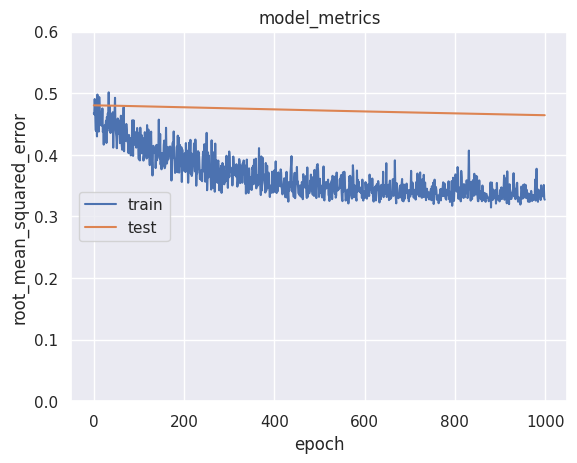

In [37]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.6)
plt.legend(['train', 'test'], loc='center left')
plt.show()

## Predicting Top 5 Recommendations

#### Preparing a DataFrame to Display Recommendation Results

In [38]:
# Menyiapkan dataframe
hotel_df = hotel[['hotel_id','hotel_name','review_score','hotel_price']]
hotel_df.columns = ['id','hotel_name','review_score','hotel_price']
df = rating.copy()

#### Setting up a User Sample to Display Recommendations

#### Searching for Users

In [39]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_data_visited_by_user_data = df[df.User_Id == user_id]

#### Searching for Locations that Users Have Not Visited

In [40]:
# Create hotel_visited_by_user DataFrame for the specified user
hotel_visited_by_user = rating[rating['User_Id'] == user_id]

# Ensure hotel_to_hotel_encoded and hotel_encoded_to_hotel are defined
hotel_to_hotel_encoded = {hotel: idx for idx, hotel in enumerate(hotel_df['id'].unique())}
hotel_encoded_to_hotel = {idx: hotel for hotel, idx in hotel_to_hotel_encoded.items()}

# Create user_hotel_array based on the hotel's encoded values
user_hotel_array = [[hotel_to_hotel_encoded[hotel]] for hotel in hotel_df['id'].values]

In [41]:
# Membuat data lokasi yang belum dikunjungi user
hotel_not_visited = hotel_df[~hotel_df['id'].isin(hotel_visited_by_user['hotel_id'].values)]['id']
hotel_not_visited = list(set(hotel_not_visited).intersection(set(hotel_to_hotel_encoded.keys())))

hotel_not_visited = [[hotel_to_hotel_encoded.get(x)] for x in hotel_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_hotel_array = np.hstack(
    ([[user_encoder]] * len(hotel_not_visited), hotel_not_visited)
)

### Displaying Recommendation Results for Users

In [42]:
# Mengambil top 5 recommendation
ratings = model.predict(user_hotel_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_hotel_ids = [
    hotel_encoded_to_hotel.get(hotel_not_visited[x][0]) for x in top_ratings_indices
]


print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating Hotel paling tinggi dari user')
print('----' * 15)

top_place_user = (
    hotel_visited_by_user.sort_values(
        by = 'hotel_rating',
        ascending=False
    )
    .head(5)
    .hotel_id.values
)

hotel_df_rows = hotel_df[hotel_df['id'].isin(top_place_user)]
for row in hotel_df_rows.itertuples():
    print(row.hotel_name, ':', row.review_score)

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)

recommended_hotel = hotel_df[hotel_df['id'].isin(recommended_hotel_ids)]
for row, i in zip(recommended_hotel.itertuples(), range(1, 8)):
    print(f"{i}. {row.hotel_name} \n    Harga Tiket Masuk {row.hotel_price}, Rating Wisata {row.review_score}\n")

print('===' * 15)

1/1 [==============================] - 0s 162ms/step
Daftar rekomendasi untuk: User 263

------------------------------------------------------------
Tempat dengan rating Hotel paling tinggi dari user
------------------------------------------------------------
THE 101 Malang OJ : 4.4

------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1. Golden Tulip Hoolland Resort Batu 
    Harga Tiket Masuk Rp900,000, Rating Wisata 4.9

2. Grand Mercure Malang Mirama 
    Harga Tiket Masuk Rp977,500, Rating Wisata 4.9

3. Hotel Montana Dua Malang 
    Harga Tiket Masuk Rp295,731, Rating Wisata 4.7

4. Hotel Tugu Malang 
    Harga Tiket Masuk Rp950,000, Rating Wisata 4.9

5. Regent's Park Hotel Malang 
    Harga Tiket Masuk Rp600,000, Rating Wisata 4.6



In [85]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
tflite_model_path = "recommender_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [86]:
# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [87]:
# Get the expected input tensor shape
input_shape = input_details[0]['shape']
print(f"Expected input tensor shape: {input_shape}")

Expected input tensor shape: [1 2]


In [89]:
# Prepare input data (user_hotel_array from previous code)
input_data = np.array(user_hotel_array, dtype=np.int64)

In [90]:
# Reshape the input data for each user-hotel pair
output_data = []
for user_id, hotel_id in input_data:
    reshaped_input = np.array([user_id, hotel_id], dtype=np.int64).reshape(1, 2)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], reshaped_input)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output = interpreter.get_tensor(output_details[0]['index'])
    output_data.append(output[0][0])  # Assuming the output is a scalar

print(output_data)

[0.5235331, 0.51385736, 0.47234088, 0.5124998, 0.5283156, 0.4795772, 0.5089153, 0.47457626, 0.50200427, 0.53725725, 0.48291674, 0.48460922, 0.49553066, 0.49034914, 0.482397, 0.52316666, 0.50716054, 0.4998221, 0.5043801, 0.505153, 0.5079374, 0.46287826, 0.47016513, 0.48183832, 0.455417, 0.47460708, 0.4930632, 0.50315887, 0.5312193]
